# Example of Clustering using the Bay Area Bike Share dataset

First, we import two classic scientific Python libraries:

- `pandas` to easily process our data and store it into _DataFrames_
- `matplotlib` for plots

(`datetime` is a module in Python's standard library)

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# 'magic command' to display the plots inline in this notebook
## (read more here: http://ipython.readthedocs.io/en/stable/interactive/magics.html)
%matplotlib inline 

## Import dataset
We'll use the [_Bay Area Bike Share dataset_](https://www.fordgobike.com/system-data) to perform clustering:

In [2]:
X = pd.read_csv('https://raw.githubusercontent.com/DataForGood-Norway/GirlsCanDoIt/master/MachineLearning/Lab/datasets/BABS_trips_2015.csv.gz', index_col=0, parse_dates=[0])

In [3]:
X.head(6)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2014-09-01,3.0,0.0,0.0,1.0,2.0,1.0,1.0,4.0,13.0,16.0,...,49.0,28.0,23.0,25.0,7.0,19.0,12.0,9.0,4.0,0.0
2014-09-02,0.0,1.0,0.0,0.0,2.0,4.0,31.0,113.0,181.0,152.0,...,43.0,51.0,111.0,198.0,141.0,52.0,24.0,12.0,9.0,9.0
2014-09-03,0.0,1.0,1.0,1.0,1.0,9.0,34.0,124.0,218.0,139.0,...,46.0,47.0,107.0,209.0,151.0,69.0,22.0,17.0,13.0,7.0
2014-09-04,2.0,0.0,0.0,0.0,3.0,7.0,37.0,107.0,195.0,125.0,...,47.0,56.0,122.0,191.0,125.0,51.0,29.0,23.0,19.0,6.0
2014-09-05,2.0,2.0,0.0,2.0,2.0,7.0,25.0,104.0,190.0,123.0,...,41.0,52.0,119.0,164.0,110.0,37.0,29.0,9.0,13.0,9.0
2014-09-06,4.0,3.0,0.0,0.0,0.0,1.0,3.0,7.0,15.0,26.0,...,43.0,30.0,44.0,28.0,47.0,37.0,9.0,8.0,5.0,3.0


In [4]:
X.shape

(365, 24)

The dataset has:
- 365 samples (or units), each of them collected on a different day in a year
- 24 features (or variables), each of them representing the hourly bike count

## Clustering algorithm
We have no knowledge regarding:
- the number of groups we should divide our data points (hourly counts) in,
- which data point belongs to which group.

We'll perform a [k-means clustering](https://www.datascience.com/blog/k-means-clustering): as a result we'll end up with $k$ groups of hourly bike counts having similar characteristics.

The algorithm most commonly used to do clustering is [`KMeans`](http://scikit-learn.org/stable/modules/clustering.html#k-means) from the Python library `scikit-learn`.

In [5]:
from sklearn.cluster import KMeans

We pick a range of values for $k$ and we fit and evaluate each clustering setup:

In [6]:
ks = range(2, 10)
scores = [-KMeans(k).fit(X).score(X) for k in ks]

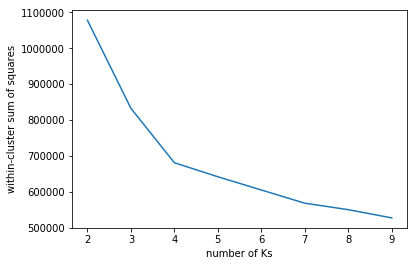

In [7]:
plt.plot(ks, scores)
plt.ylabel("within-cluster sum of squares")
plt.xlabel("number of Ks")
plt.show()

This plot shows how the _within-cluster distance_ between data points decreases when the number of clusters $k$ is increasing.

The bigger the number ($k$) of groups we have:
- the more similar to each other are the data points we'll have in each cluster (less dispersion)
- the less generalizable the results we can infer from this data grouping, since each cluster will be less and less populated (overfitting)

We want to stop in the "sweet spot" where we see the biggest decrease in _within-cluster distance_ keeping the number of groups as low as possible in order to get a simpler and effective model.
That point is the "elbow point", and in this case it is stopping at $k=4$.

In [8]:
model = KMeans(4).fit(X)

**Question: what can we infer from this plot?**

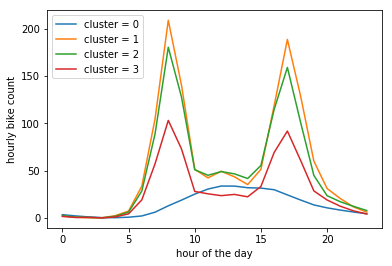

In [9]:
for n, center in enumerate(model.cluster_centers_):
    plt.plot(center, label="cluster = {}".format(n))
plt.ylabel("hourly bike count")
plt.xlabel("hour of the day")
plt.legend()

Plotting these 4 groups we see how 3 of them have a big spike in hourly bike count in the morning and in the evening.

So: if we're able to see the rush hours, could it be that the only cluster that didn't catch that variation (`cluster = 2`) might represent weekends (as opposed to working days)?
We'll now try to look if the data has some underlying weekly variations:

In [10]:
labels = pd.DataFrame({'date': X.index, 'cluster': model.labels_})

In [11]:
from calendar import day_abbr, month_abbr

In [12]:
labels['day'] = labels.date.apply(lambda x: day_abbr[x.weekday()])
labels['month'] = labels.date.apply(lambda x: month_abbr[x.month])

In [13]:
weekday_counts = labels.groupby(['cluster', 'day']).size().rename('count').reset_index()

In [14]:
better_counts = weekday_counts.reset_index().pivot(columns='day', values='count', index='cluster').fillna(0)
better_counts

day,Fri,Mon,Sat,Sun,Thu,Tue,Wed
cluster,,,,,,,
0,4.0,3.0,52.0,52.0,4.0,0.0,2.0
1,0.0,41.0,0.0,0.0,34.0,42.0,39.0
2,44.0,6.0,0.0,0.0,13.0,6.0,6.0
3,4.0,3.0,0.0,0.0,1.0,4.0,5.0


**Discuss the histogram below: what observations can be made?**

Text(0,0.5,'count')

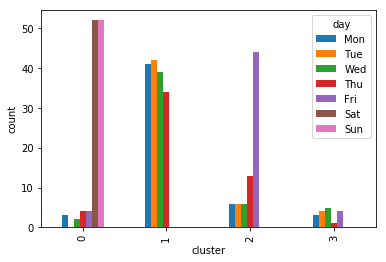

In [15]:
better_counts[[day_abbr[i] for i in range(7)]].plot.bar()
plt.ylabel('count')

In this plot we see how the `cluster = 2` was in fact populated by data points in weekends.

Let's now try the same analysis with months of the year:

**Looking at this histogram, can we add more information to what we inferred before?**

Text(0,0.5,'count')

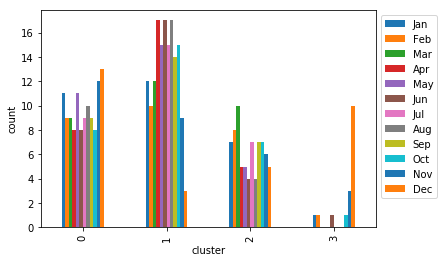

In [16]:
(labels
 .groupby(['cluster', 'month'])
 .day.count().reset_index()
 .pivot(columns='month', values='day', index='cluster')
 .fillna(0)[[month_abbr[i] for i in range(1, 13)]]
 .plot.bar())
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('count')